# Basic Classifier using InferDotNet

## Introduction

This notebook looks at building a `1-feature` probabilistic classifier - a.k.a. a Bayes point machine. Whilst reading the <a href='https://mbmlbook.com/EmailClassifier_A_model_for_classification.html'>Model Based Machine Learning</a> ebook by <a href="https://www.microsoft.com/en-us/research/people/jwinn/?from=http%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fpeople%2Fjwinn%2F">John Winn</a> et al. from <a href="https://www.microsoft.com/en-us/research/">Microsoft Reseach</a> I found it very confusing diving right into the model based machine learning approach and was looking for a way to tie MBML with traditional ML - this notebook is the result.

Although the <a href="https://mbmlbook.com/index.html">MBML book</a> is a brilliant book, the first 3 chapters cover very probabilistic approaches to solving problem - as it should, as that is what the book is all about 😅.

However, coming from traditional machine learning I was glad to see that in Chapter 4 they build a binary classifier, albeit in a probabilistic fashion. The MBML book uses <a href="https://en.wikipedia.org/wiki/Factor_graph#:~:text=A%20factor%20graph%20is%20a,the%20factorization%20of%20a%20function.&text=Factor%20graphs%20generalize%20constraint%20graphs,where%20all%20factors%20are%20constraints.">factor graphs</a> across the board - if you're not yet aquited with factor graphs, the TLDR from  <a href="https://en.wikipedia.org/wiki/Factor_graph#:~:text=A%20factor%20graph%20is%20a,the%20factorization%20of%20a%20function.&text=Factor%20graphs%20generalize%20constraint%20graphs,where%20all%20factors%20are%20constraints.">wikipedia</a>:

> A factor graph is a bipartite graph representing the factorization of a function. Given a factorization of a function $g$,
> $$g(X_1,X_2,\dots,X_n) = \prod_{j=1}^m f_j(S_j),$$
> where ${\displaystyle S_{j}\subseteq \{X_{1},X_{2},\dots ,X_{n}\}}$, the corresponding factor graph ${\displaystyle G=(X,F,E)}$ consists of variable vertices ${\displaystyle X=\{X_{1},X_{2},\dots ,X_{n}\}}$, factor vertices ${\displaystyle F=\{f_{1},f_{2},\dots ,f_{m}\}}$, and edges ${\displaystyle E}$. The edges depend on the factorization as follows: there is an undirected edge between factor vertex ${\displaystyle f_{j}}$ and variable vertex ${\displaystyle X_{k}}$  iff ${\displaystyle X_{k}\in S_{j}}$.

In other words, factor graphs are a way to factorize functions, and factor graphs as used in MBML specifically where $g(X_1,X_2,\dots,X_n)$ is a joint distribution or a joint likelihood function, and the factorization depends on the conditional independencies among the variables. These factor graphs can be solved using various algorithms like Belief propagation, also known as sum-product message passing, and a go-to platform to perform these calculations is C#'s dotnet using the Microsoft funded inferDotNet package. 

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from scipy import special
import numpy as np

In [2]:
# Gaussian CDF
def cdf(x,mu,sig):
    return 0.5*(1+special.erf((x-mu)/(sig*np.sqrt(2))))

### Config

In [3]:
data_dir = Path('../data')
input_dataset = data_dir/'iris.csv'
output_dataset = data_dir/'iris-one-feature.csv'
model_output = data_dir/'model-output.csv'

### Data Acquisition

In [4]:
df = pd.read_csv(input_dataset)

# We subset the data to only have Setosa and Virginica
df_2_class = df[df['class'].\
    isin(['Iris-virginica', 'Iris-setosa'])].copy()

In [5]:
df_2_class.sample(2)

,sepallength,sepalwidth,petallength,petalwidth,class
144,6.7,3.3,5.7,2.5,Iris-virginica
138,6.0,3.0,4.8,1.8,Iris-virginica


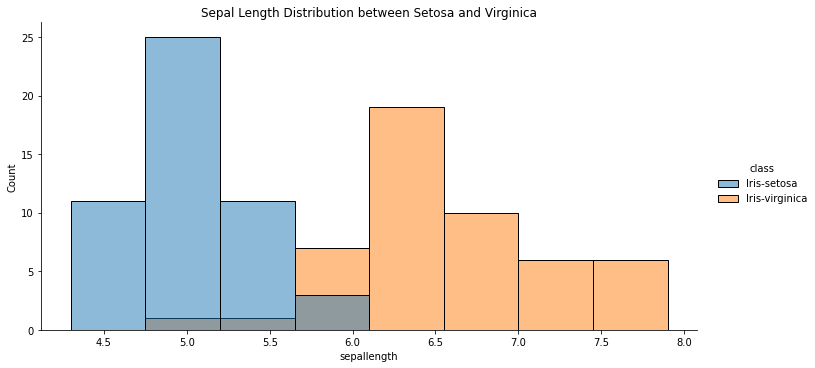

In [6]:
f = sns.displot(data=df_2_class,
                x='sepallength',
                aspect=2,
                hue='class')
plt.title('Sepal Length Distribution between Setosa and Virginica');

In [7]:
df_2_class.loc[df_2_class['class'] == 'Iris-setosa', 'is_setosa'] = 1
df_2_class.loc[df_2_class['class'] == 'Iris-virginica', 'is_setosa'] =  0

In [8]:
# When scaling this go a bit weird - still need to figure out why
# from sklearn.preprocessing import StandardScaler
# scaler = MinMaxScaler(feature_range=(-1,1))
# scaler = StandardScaler()
# df_2_class.sepallength = scaler.fit_transform(df_2_class.sepallength.values.reshape(-1,1)).flatten()

In [9]:
df_2_class[['sepallength', 'is_setosa']].\
to_csv(output_dataset,
       header=False,
       sep='|',
       index=False)

## Run Model

In [10]:
cmd = f'dotnet run --project ../model/ ../data/ iris-one-feature.csv'

In [11]:
!{cmd}

======Compiling model...done.
Iterating: 
.........|.........|.........|.........|.........| 50
.........|.........|.........|.........|.........| 100
.........|.........|.........|.........|.........| 150
.........|.........|.........|.........|.........| 200
Gaussian(-1.037, 0.08601)
Gaussian(-4.81, 9.654)
=

## Analyze Results

In [12]:
df_results = pd.read_csv(data_dir/'results.csv', sep=';')
df_results

,variable,mean,variance
0,postWeight,-1.037311,0.086011
1,postThreshold,-4.809625,9.653623


In [13]:
postWeightMean = df_results[df_results.variable == "postWeight"]['mean'].values[0]
postWeightVariance = df_results[df_results.variable == "postWeight"]['variance'].values[0]
postThresholdMean = df_results[df_results.variable == "postThreshold"]['mean'].values[0]
postThresholdVariance = df_results[df_results.variable == "postThreshold"]['variance'].values[0]
postThresholdStandardDev = np.sqrt(postThresholdVariance)
postWeightMean, postWeightVariance, postThresholdMean, postThresholdVariance, postThresholdStandardDev

(-1.0373108043430328,
 0.08601064880969662,
 -4.809624710877233,
 9.653623138701038,
 3.1070280234817704)

In [14]:
sampledWeight = np.random.normal(postWeightMean, np.sqrt(postWeightVariance))
sampledWeight

-1.1201174585344578

In [15]:
df_2_class['score'] = df_2_class.sepallength * sampledWeight

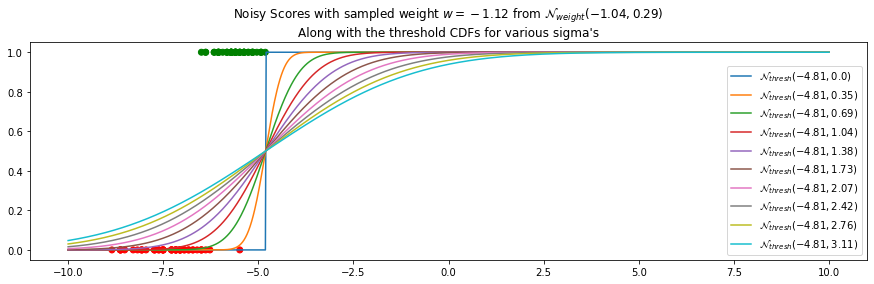

In [16]:
x_min_max = 10
x = np.linspace(-1*x_min_max, x_min_max, 1000)
fig = plt.figure(figsize=(15,4))

for sigma in [postThresholdStandardDev* v for v in np.linspace(0.0001, 1, 10)]:
    sig = str(round(sigma, 2))
    mean = str(round(postThresholdMean, 2))
    label = "${\\mathcal {N}_{thresh}}("+mean+","+sig+")$"
    y = cdf(x, postThresholdMean, sigma)
    plt.plot(x, y, label=label)

sig = str(round(np.sqrt(postWeightVariance), 2))
mean = str(round(postWeightMean, 2))
plt.scatter(x=df_2_class.score,
            y=df_2_class.is_setosa,
            c=df_2_class.is_setosa.map({0:'red', 
                                        1:'green'}))
plt.legend()
plt.title("Noisy Scores with sampled weight $w="+str(round(sampledWeight,2))+"$"+""" from ${\\mathcal {N}_{weight}}("""+mean+","+sig+")$"+"""
Along with the threshold CDFs for various sigma's""");